In [1]:
import numpy as np
import pandas as pd

## Inputting Parameters

In [132]:
# method
alphas = np.linspace(.025,.95,30)
filesScore = ["Pij_outlier_removed_2009.csv","Pij_outlier_removed_2010.csv",
              "Pij_outlier_removed_2011.csv","Pij_outlier_removed_2012.csv",
              "Pij_outlier_removed_2013.csv","Pij_outlier_removed_2014.csv",
              "Pij_outlier_removed_2015.csv","Pij_outlier_removed_2016.csv",
              "Pij_outlier_removed_2017.csv","Pij_outlier_removed_2018.csv"]

filesPercs = ["2009_win_perc.csv","2010_win_perc.csv","2011_win_perc.csv","2012_win_perc.csv",
             "2013_win_perc.csv","2014_win_perc.csv","2015_win_perc.csv",
             "2016_win_perc.csv","2017_win_perc.csv","2018_win_perc.csv"]

namesCols = ["win_perc_2009","win_perc_2010","win_perc_2011","win_perc_2012",
            "win_perc_2013","win_perc_2014","win_perc_2015",
            "win_perc_2016","win_perc_2017","win_perc_2018"]

## Defining the Function

In [131]:
def alpha_optimize_corr(method,alphas,filesScore,filesPercs,namesCols,nSims = 100000,weighted = True):
    # intializing two vectors to store results
    wins_corr_total = np.zeros(len(alphas))
    score_corr_total = np.zeros(len(alphas))
    indexer = 0
    
    # iterating over all alphas
    for alpha_try in alphas:
        
        if(alpha_try <= .1):
            nSims_use = nSims
        else:
            nSims_use = 10000
        
        # initializing the two correlations
        mc_corr_wins = 0
        mc_corr_score = 0
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            # converting to a numpy array
            data2 = np.array(data)
            
            if(weighted == False):
                data2[data2!=0] = 1
            
            # making the Pij matrix
            Pij = data2/data2.sum(axis=0)
            
            # If we want the teleportation probabilties unifrom,
            # or based on team winning perc
            if method == 0:
                # making the teleporting probabilities uniform
                v = np.ones(32)/32
                v = v[np.newaxis]
                v = v.T
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]   
            else:
                # making the teleporting probabilities proportional to
                # the teams winning percentages
                v = np.array(stats1[namesCols[year_of_data]])
                v = v[np.newaxis]
                v = v.T
                v = v/np.sum(v)
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]
                
            # initializing our first guess
            x0 = np.ones(32)/32
            x0 = x0[np.newaxis]
            x0 = x0.T
            
            # performing the simulation
            for i in range(nSims_use):
                x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(x0))[::-1]
            x0_df = np.squeeze(x0[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': x0_df, 'wins': 32*16/2*x0_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Computing the correlation
            score = np.array(output["score"])
            wins1 = np.array(output[namesCols[year_of_data]])
            wins2 = np.array(output[namesCols[year_of_data + 1]])
            
            wins_corr = np.corrcoef(wins1, wins2)[0,1]
            PageRank_corr = np.corrcoef(score, wins2)[0,1]
            
            # Storing the results
            mc_corr_wins += wins_corr
            mc_corr_score += PageRank_corr
            
        # Updating the correlations
        wins_corr_total[indexer] = mc_corr_wins/(len(filesScore) - 1)
        score_corr_total[indexer] = mc_corr_score/(len(filesScore) - 1)
        indexer += 1
        
    return wins_corr_total,score_corr_total

In [134]:
wins_corr0,score_corr0 = alpha_optimize_corr(0,alphas,filesScore,filesPercs,namesCols)

In [97]:
wins_corr1,score_corr1 = alpha_optimize_corr(1,alphas,filesScore,filesPercs,namesCols)

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

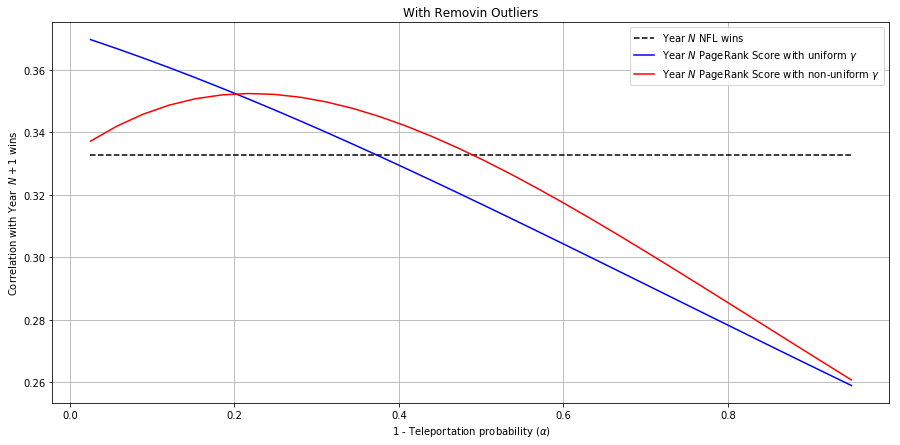

In [135]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wins_corr0,'k--',label = r'Year $N$ NFL wins')
plt.plot(alphas,score_corr0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,score_corr1,'r-',label = r'Year $N$ PageRank Score with non-uniform $\gamma$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel(r'Correlation with Year  $N+1$ wins')
plt.grid()
plt.legend()
plt.title("With Removing Outliers")
plt.show()

## Without Removing Outliers

In [110]:
# method
alphas = np.linspace(.025,.95,30)
filesScore = ["Pij_2009.csv","Pij_2010.csv",
              "Pij_2011.csv","Pij_2012.csv",
              "Pij_2013.csv","Pij_2014.csv",
              "Pij_2015.csv","Pij_2016.csv",
              "Pij_2017.csv","Pij_2018.csv"]

filesPercs = ["2009_win_perc.csv","2010_win_perc.csv","2011_win_perc.csv","2012_win_perc.csv",
             "2013_win_perc.csv","2014_win_perc.csv","2015_win_perc.csv",
             "2016_win_perc.csv","2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2009","win_perc_2010","win_perc_2011","win_perc_2012",
            "win_perc_2013","win_perc_2014","win_perc_2015",
            "win_perc_2016","win_perc_2017","win_perc_2018"]

In [111]:
wins_corr2,score_corr2 = alpha_optimize_corr(0,alphas,filesScore,filesPercs,namesCols)

In [112]:
wins_corr3,score_corr3 = alpha_optimize_corr(1,alphas,filesScore,filesPercs,namesCols)

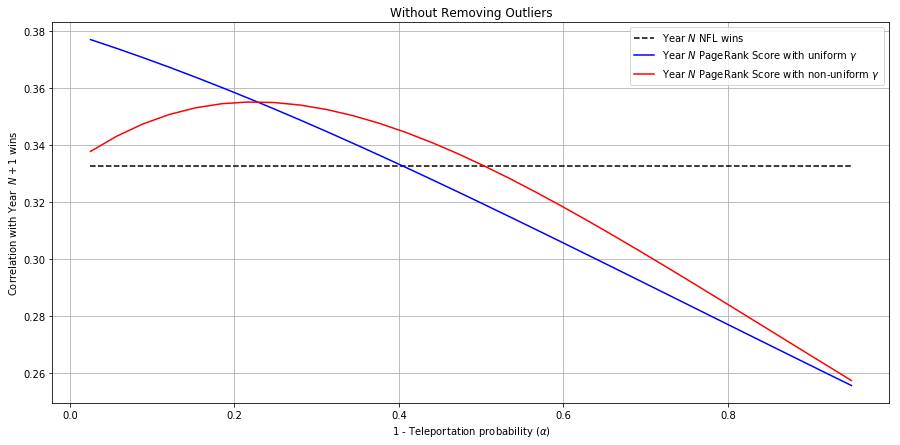

In [136]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wins_corr2,'k--',label = r'Year $N$ NFL wins')
plt.plot(alphas,score_corr2,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,score_corr3,'r-',label = r'Year $N$ PageRank Score with non-uniform $\gamma$')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')

plt.ylabel(r'Correlation with Year  $N+1$ wins')
plt.grid()
plt.title("Without Removing Outliers")
plt.legend()
plt.show()

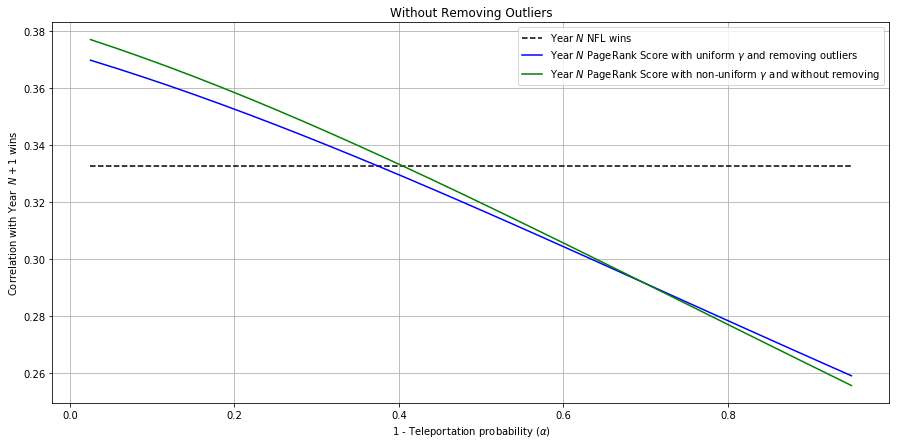

In [137]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wins_corr2,'k--',label = r'Year $N$ NFL wins')
plt.plot(alphas,score_corr0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$ and removing outliers')
plt.plot(alphas,score_corr2,'g-',label = r'Year $N$ PageRank Score with non-uniform $\gamma$ and without removing')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel(r'Correlation with Year  $N+1$ wins')
plt.grid()
plt.title("Without Removing Outliers")
plt.legend()
plt.show()

In [129]:
x = np.array([[1,0,3,1,5],[4,2,6,0,-3]])
print(x)
x[x!=0] = 1
print(x)

[[ 1  0  3  1  5]
 [ 4  2  6  0 -3]]
[[1 0 1 1 1]
 [1 1 1 0 1]]


In [138]:
wins_corr4,score_corr4 = alpha_optimize_corr(0,alphas,filesScore,filesPercs,namesCols,weighted = False)

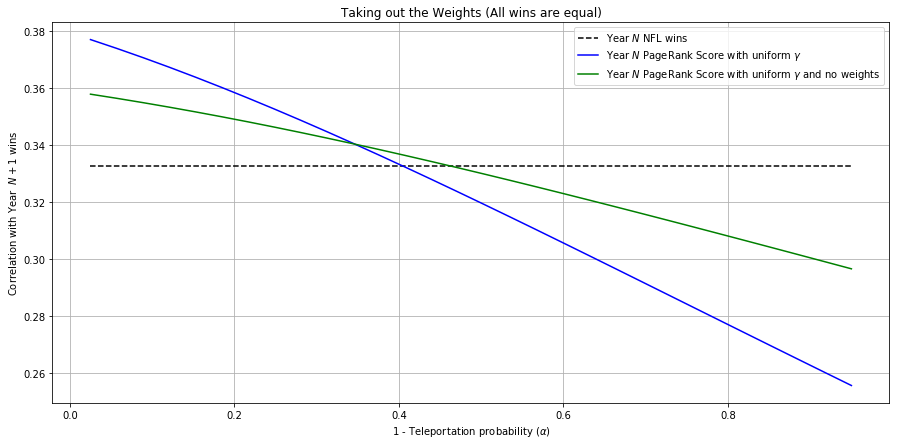

In [141]:
plt.figure(figsize=(15,7))

plt.plot(alphas,wins_corr2,'k--',label = r'Year $N$ NFL wins')
plt.plot(alphas,score_corr2,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,score_corr4,'g-',label = r'Year $N$ PageRank Score with uniform $\gamma$ and no weights')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel(r'Correlation with Year  $N+1$ wins')
plt.grid()
plt.title("Taking out the Weights (All wins are equal)")
plt.legend()
plt.show()